In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

from scripts.my_camera_cal import readValuesToUndistort
from scripts.my_camera_cal import unwarp

from scripts.my_pipeline import pipeline
from scripts.my_camera_cal import image_perspective

from scripts.my_line_finding import fit_polynomial
from scripts.my_line_finding import search_around_poly

In [2]:
mtx,dist=readValuesToUndistort("config/myvalues_to_undistort.p")

In [3]:
# Make a list of calibration images
images = glob.glob('../test_images/*.jpg')
print(images)

['../test_images\\harder1.jpg', '../test_images\\straight_lines1.jpg', '../test_images\\straight_lines2.jpg', '../test_images\\test1.jpg', '../test_images\\test2.jpg', '../test_images\\test3.jpg', '../test_images\\test4.jpg', '../test_images\\test5.jpg', '../test_images\\test6.jpg']


(720, 1280, 3)
(720, 1280, 3)


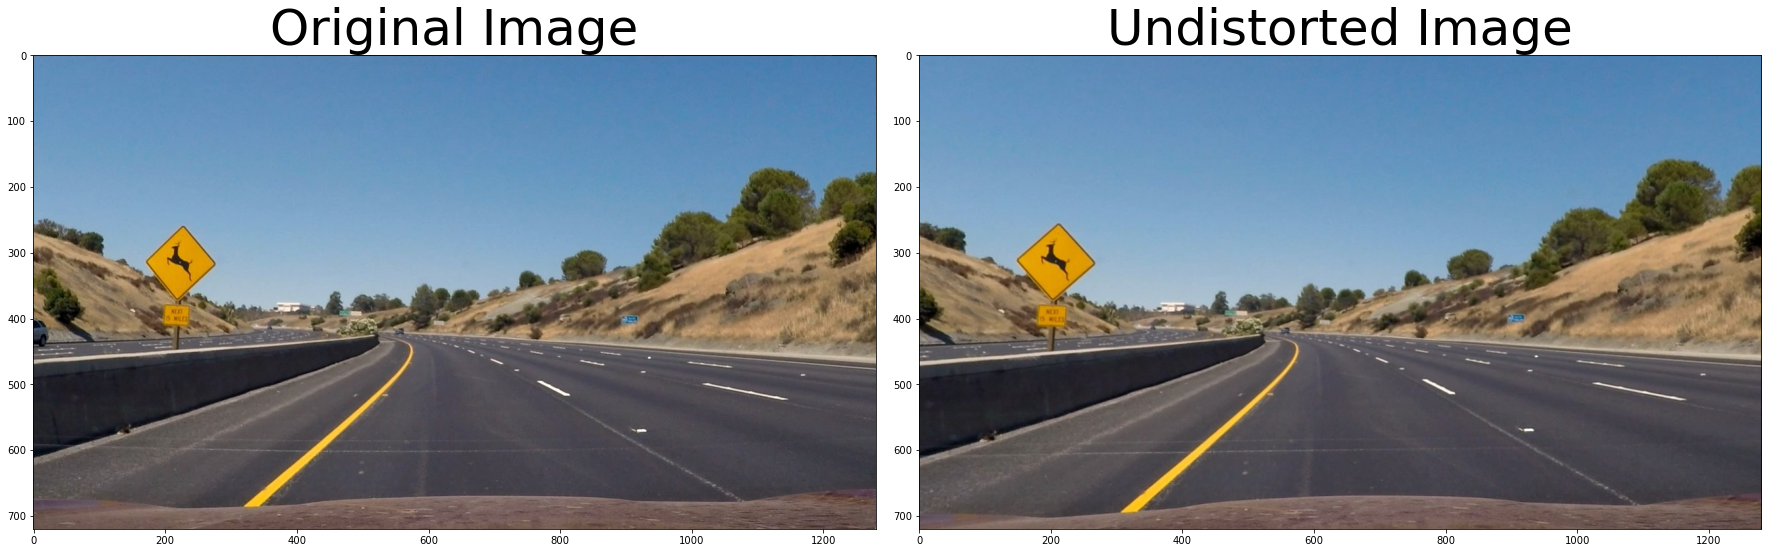

In [4]:
# Read in an image
image = mpimg.imread('../test_images/test2.jpg')
print(image.shape)

#undistort it
dst = cv2.undistort(image, mtx, dist, None, mtx)
print(dst.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280)


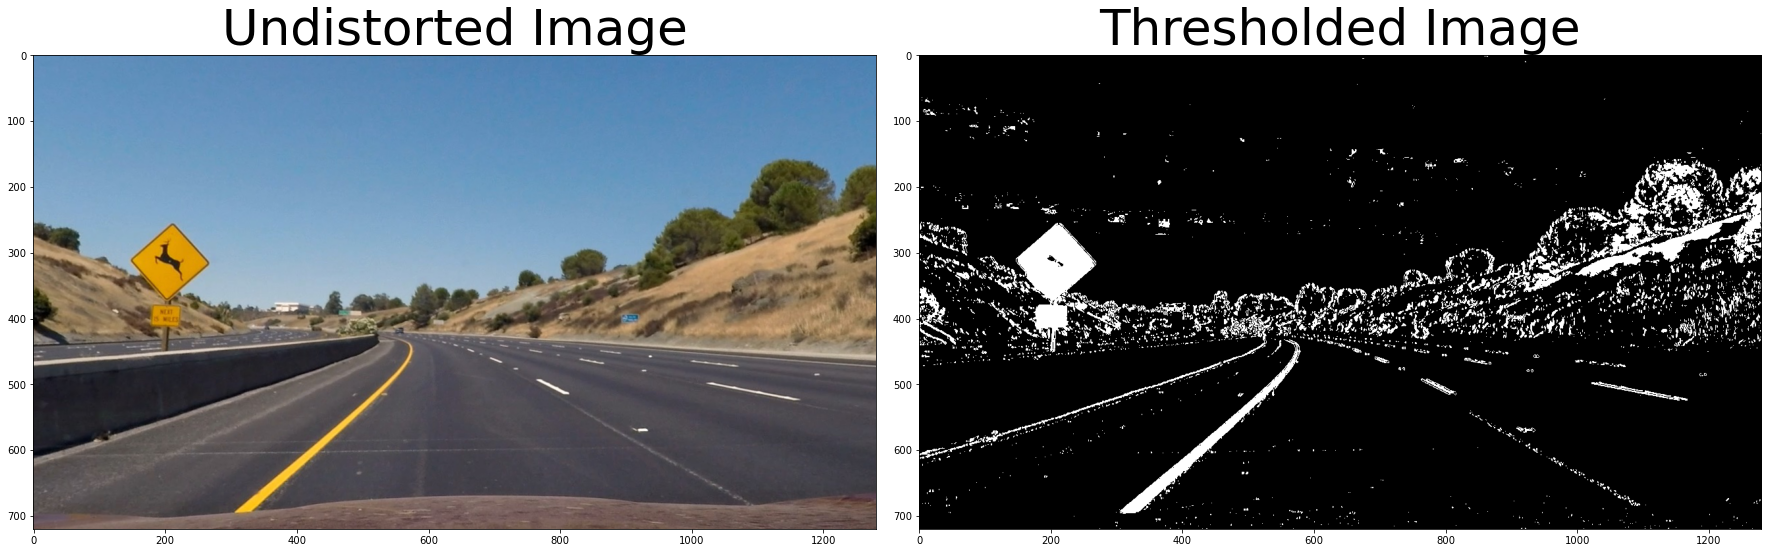

In [5]:
color_binary,combined_binary= pipeline(dst,channel='s',color_thresh=(110,255), orient='x', sobel_thresh=(20, 100))
print(combined_binary.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined_binary,cmap="gray")
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

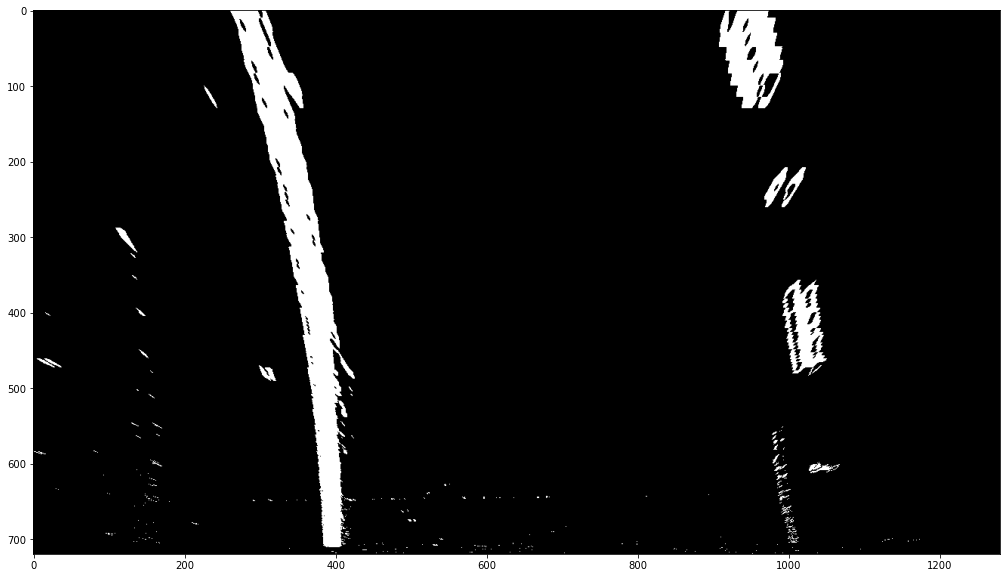

In [6]:
bird_image,M=image_perspective(combined_binary)
plt.figure(figsize=(20,10))
plt.imshow(bird_image,cmap="gray")

### Now finding lanes

[-2.06014798e-04  3.00151806e-01  2.86603428e+02] [-3.20495194e-04  3.32097571e-01  9.33805210e+02]


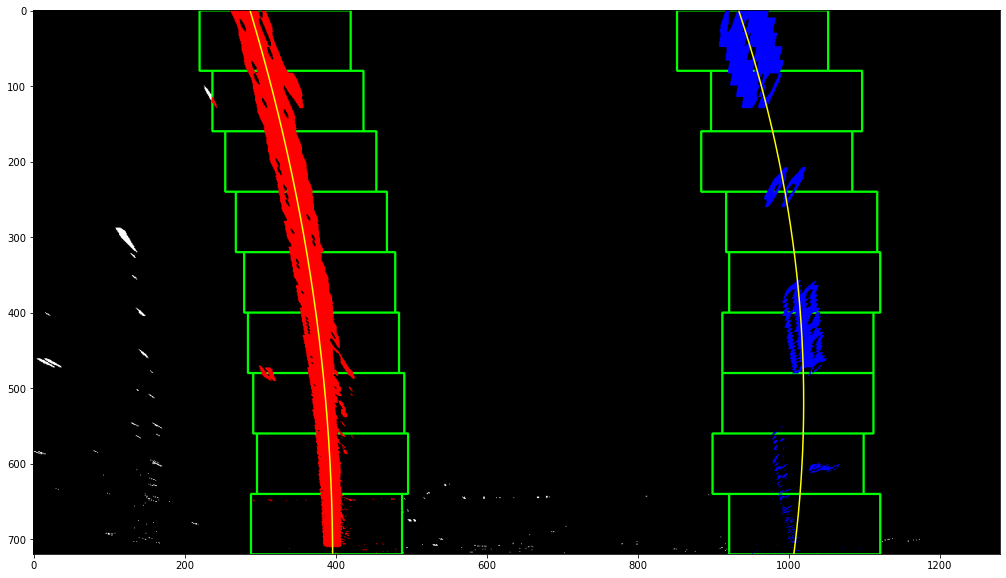

In [7]:
#You have to call the function and imshow together to see the polynomial inside the plot
plt.figure(figsize=(20,10))
l_fit,r_fit,polynomial_image=fit_polynomial(bird_image)
print(l_fit,r_fit)
plt.imshow(polynomial_image)

In [11]:
z = np.zeros_like(bird_image)
bird_lane = np.dstack((z, z, z))

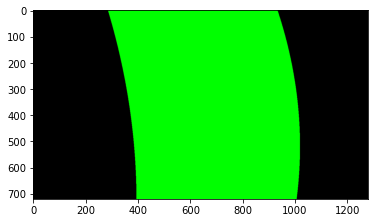

In [15]:
plt.imshow(bird_lane)

I need the coefficients

l_fit r_fit

In [13]:
kl, kr = l_fit, r_fit
h=bird_lane.shape[0]
ys = np.linspace(0, h - 1, h)
lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]

In [14]:
pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
pts = np.hstack((pts_left, pts_right))
    
cv2.fillPoly(bird_lane, np.int_(pts), (0,255,0))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [17]:
shape = (bird_lane.shape[1], bird_lane.shape[0])

source=np.float32 ([(580, 460), (202, 720), (1110, 720), (703, 460)])
destino=np.float32([(336, 0), (336, 720), (976, 720), (976, 0)])

inv_M=cv2.getPerspectiveTransform(destino, source)


ground_lane = cv2.warpPerspective(bird_lane, inv_M, shape)

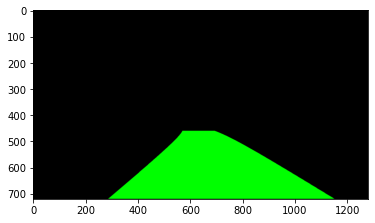

In [18]:
plt.imshow(ground_lane)

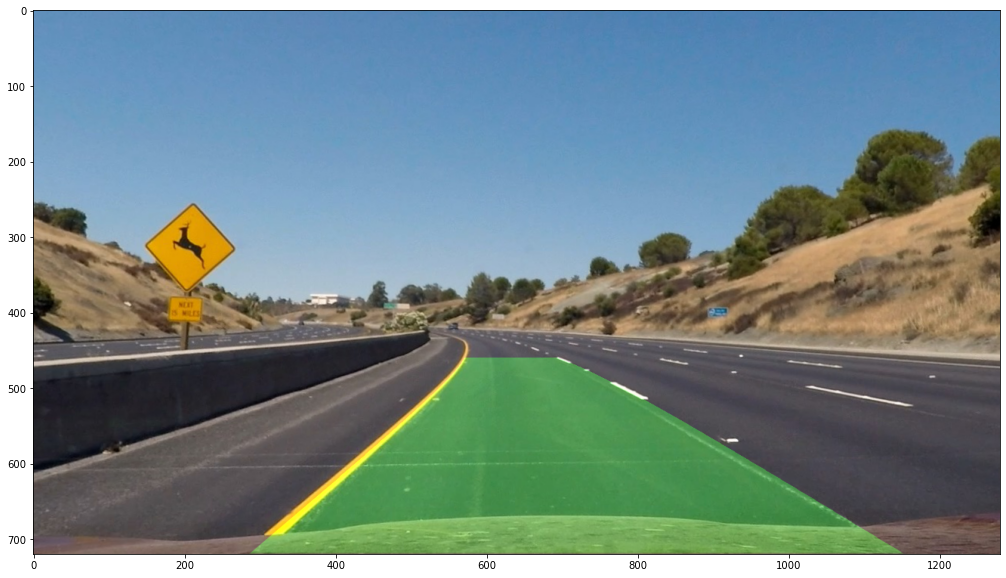

In [20]:
final_image = cv2.addWeighted(dst, 1, ground_lane, 0.3, 0)
plt.figure(figsize=(20,10))
plt.imshow(final_image)

In [21]:
#this should be called

# back_to_world(dst,bird_image,l_fit,r_fit)


def back_to_world(real_image,bird_image,l_fit,r_fit,source=np.float32 ([(580, 460), (202, 720), (1110, 720), (703, 460)]), 
                  destino=np.float32([(336, 0), (336, 720), (976, 720), (976, 0)])):
    z = np.zeros_like(bird_image)
    bird_lane = np.dstack((z, z, z))
    
    kl, kr = l_fit, r_fit
    h=bird_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(bird_lane, np.int_(pts), (0,255,0))
    
    i_shape = (bird_lane.shape[1], bird_lane.shape[0])

    #source=np.float32 ([(580, 460), (202, 720), (1110, 720), (703, 460)])
    #destino=np.float32([(336, 0), (336, 720), (976, 720), (976, 0)])

    inv_M=cv2.getPerspectiveTransform(destino, source)


    ground_lane = cv2.warpPerspective(bird_lane, inv_M, i_shape)
    
    final_image = cv2.addWeighted(real_image, 1, ground_lane, 0.3, 0)
    return final_image

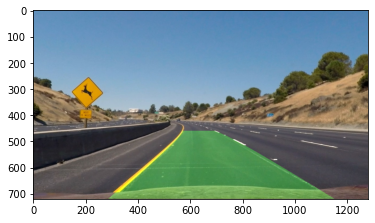

In [22]:
final=back_to_world(dst,bird_image,l_fit,r_fit)
plt.imshow(final)

(720, 1280)


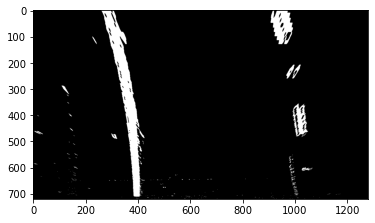

In [10]:
print(bird_image.shape)
plt.imshow(bird_image,cmap="gray")

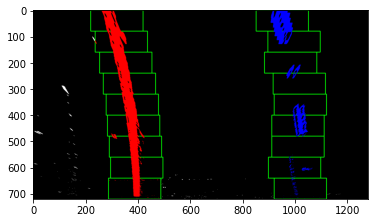

In [8]:
plt.imshow(polynomial_image)

In [ ]:
#You have to call the function and imshow together to see the polynomial inside the plot
plt.figure(figsize=(20,10))
l_fit2,r_fit2,polynomial_image2=search_around_poly(bird_image,l_fit,r_fit)
print(l_fit2,r_fit2)
plt.imshow(polynomial_image2)